Ramas, Ron Patrick G.\
Daganta, Reynat A.

## **Assignment 2 in Data Analytics**

---

###  **Import Libraries**

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from scipy.stats import gaussian_kde

os.environ["OMP_NUM_THREADS"] = "1"

In [ ]:

sessa_df = pd.read_csv("med_events.csv")

sessa_df.tail()


,PATIENT_ID,DATE,PERDAY,CATEGORY,DURATION
1075,100,03/05/2034,6,medB,30
1076,100,04/07/2034,6,medB,30
1077,100,04/26/2034,6,medB,30
1078,100,05/26/2034,6,medB,30
1079,100,07/09/2034,4,medB,30


In [ ]:
sessa_df.rename(columns={
    "PATIENT_ID": "pnr",
    "DATE": "eksd",
    "CATEGORY": "ATC",
    "PERDAY": "perday",
    "DURATION": "dur_original",
}, inplace=True)

sessa_df['eksd'] = pd.to_datetime(sessa_df['eksd'])

### **ATC Codes**

In [ ]:
print(sessa_df['ATC'].unique())

['medA' 'medB']


### **Density**

In [ ]:
print(sessa_df['ATC'].value_counts())

ATC
medA    549
medB    531
Name: count, dtype: int64


### **Sessa Empirator Estimator using K-Means**

In [18]:
def see(atc_code, sessa_df):
    # Filter for the chosen drug (ATC code)
    df = sessa_df[sessa_df['ATC'] == atc_code].copy()
    
    # Make a copy to later merge back
    Drug_see_p0 = df.copy()
    drug_see_p1 = df.copy()
    
    # Sort by patient (pnr) and date (eksd)
    drug_see_p1 = drug_see_p1.sort_values(['pnr', 'eksd'])
    # Create a column with the previous date for each patient
    drug_see_p1['prev_eksd'] = drug_see_p1.groupby('pnr')['eksd'].shift(1)
    # Remove the first event for each patient (NA in prev_eksd)
    drug_see_p1 = drug_see_p1.dropna(subset=['prev_eksd'])
    
    # For each patient, randomly sample one record (using a fixed random_state for reproducibility)
    drug_see_p1 = (drug_see_p1
                   .groupby('pnr', group_keys=False)
                   .apply(lambda x: x.sample(1, random_state=42))
                   .reset_index(drop=True))
    # Keep only the needed columns
    drug_see_p1 = drug_see_p1[['pnr', 'eksd', 'prev_eksd']]
    
    # Compute event interval (in days) between successive events
    drug_see_p1['event_interval'] = (drug_see_p1['eksd'] - drug_see_p1['prev_eksd']).dt.days.astype(float)
    
    # --- ECDF Computation ---
    sorted_intervals = np.sort(drug_see_p1['event_interval'].values)
    n = len(sorted_intervals)
    ecdf_y = np.arange(1, n+1) / n
    dfper = pd.DataFrame({'x': sorted_intervals, 'y': ecdf_y})
    # Only consider the part of the ECDF up to 80%
    dfper_80 = dfper[dfper['y'] <= 0.8]
    ni = dfper_80['x'].max()
    
    # Plot the 80% and 100% ECDFs plus a bar plot of patient frequencies
    fig, axs = plt.subplots(1, 3, figsize=(18, 5))
    axs[0].plot(dfper_80['x'], dfper_80['y'], marker='.', linestyle='none')
    axs[0].set_title('80% ECDF')
    axs[1].plot(dfper['x'], dfper['y'], marker='.', linestyle='none')
    axs[1].set_title('100% ECDF')
    m1 = drug_see_p1['pnr'].value_counts()
    axs[2].bar(m1.index.astype(str), m1.values)
    axs[2].set_title('Frequency of pnr')
    plt.show()
    
    # --- Density Estimation on Log(Event Interval) ---
    Drug_see_p2 = drug_see_p1[drug_see_p1['event_interval'] <= ni].copy()
    log_intervals = np.log(Drug_see_p2['event_interval'].values)
    kde = gaussian_kde(log_intervals)
    x1 = np.linspace(log_intervals.min(), log_intervals.max(), 100)
    y1 = kde(x1)
    plt.figure()
    plt.plot(x1, y1)
    plt.title('Log(event interval) Density')
    plt.show()
    
    # Create a DataFrame from the density estimates and scale it
    a = pd.DataFrame({'x': x1, 'y': y1})
    scaler = StandardScaler()
    a_scaled = scaler.fit_transform(a)
    
    # --- Determine Optimal Number of Clusters via Silhouette Analysis ---
    silhouette_scores = {}
    for k in range(2, min(10, len(a_scaled)) + 1):
        km = KMeans(n_clusters=k, random_state=1234, n_init=10)  # Fix warning
        labels = km.fit_predict(a_scaled)
        score = silhouette_score(a_scaled, labels)
        silhouette_scores[k] = score
    if silhouette_scores:
        max_cluster = max(silhouette_scores, key=silhouette_scores.get)
    else:
        max_cluster = 1
    print("Optimal number of clusters (via silhouette):", max_cluster)
    
    # --- K-Means Clustering on the ECDF x-values ---
    km_final = KMeans(n_clusters=max_cluster, random_state=1234, n_init=10)  # Fix warning
    dfper['cluster'] = km_final.fit_predict(dfper[['x']])
    
    # Compute cluster-wise summaries on log(x)
    dfper['log_x'] = np.log(dfper['x'])
    cluster_stats = (dfper.groupby('cluster')['log_x']
                     .agg(['min', 'max', 'median'])
                     .reset_index())
    cluster_stats['Minimum'] = np.exp(cluster_stats['min'])
    cluster_stats['Maximum'] = np.exp(cluster_stats['max'])
    cluster_stats['Median'] = np.exp(cluster_stats['median'])
    cluster_stats = cluster_stats[['cluster', 'Minimum', 'Maximum', 'Median']]
    cluster_stats = cluster_stats[cluster_stats['Median'] > 0]
    
    # --- Assign Clusters via a Cross Join ---
    results = drug_see_p1.merge(cluster_stats, how='cross')
    results['Final_cluster'] = np.where(
        (results['event_interval'] >= results['Minimum']) & 
        (results['event_interval'] <= results['Maximum']),
        results['cluster'],
        np.nan
    )
    results = results.dropna(subset=['Final_cluster'])
    results['Final_cluster'] = results['Final_cluster'].astype(int)
    
    # Determine the most frequent cluster among these assignments
    most_freq_cluster = results['Final_cluster'].value_counts().idxmax()
    median_value = cluster_stats.loc[cluster_stats['cluster'] == most_freq_cluster, 'Median'].values[0]
    
    # Merge the results (per patient) back into drug_see_p1
    results_subset = results[['pnr', 'Median', 'Final_cluster']].drop_duplicates(subset=['pnr'])
    drug_see_p1 = pd.merge(drug_see_p1, results_subset, on='pnr', how='left')
    drug_see_p1['Median'] = drug_see_p1['Median'].fillna(median_value)
    drug_see_p1['Final_cluster'] = drug_see_p1['Final_cluster'].fillna(0).astype(int)
    
    # --- Prepare Final Output ---
    results_final = pd.merge(Drug_see_p0, 
                             drug_see_p1[['pnr', 'Median', 'Final_cluster']], 
                             on='pnr', how='left')
    results_final['Median'] = results_final['Median'].fillna(median_value)
    results_final['Final_cluster'] = results_final['Final_cluster'].fillna(0).astype(int)
    
    return results_final



### **SEE Assumption**

C:\Users\ronpa\AppData\Local\Temp\ipykernel_10084\3070832694.py:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(1, random_state=42))


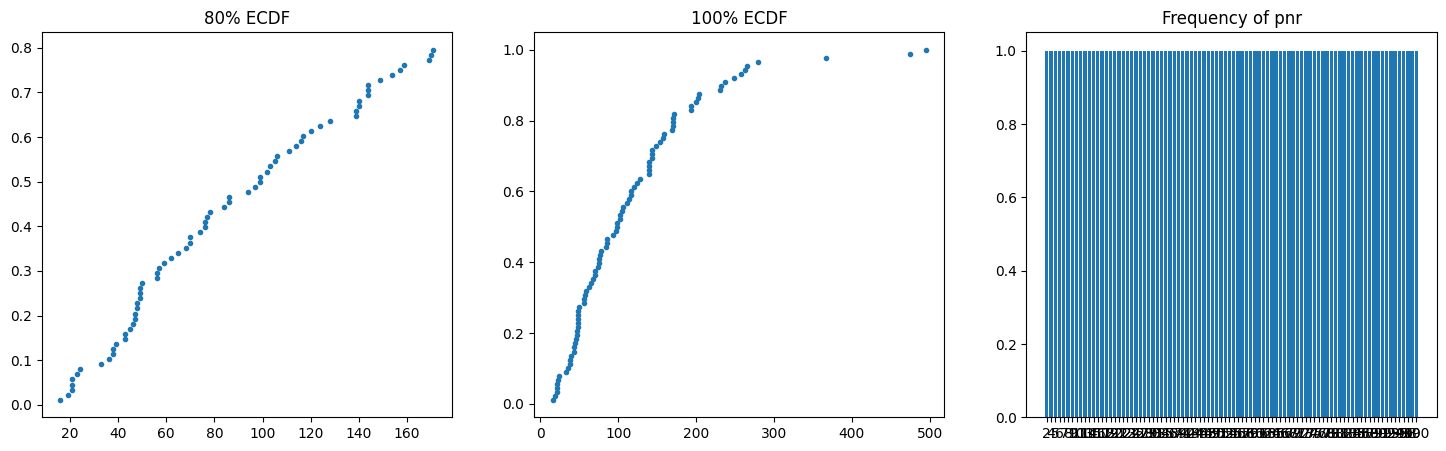

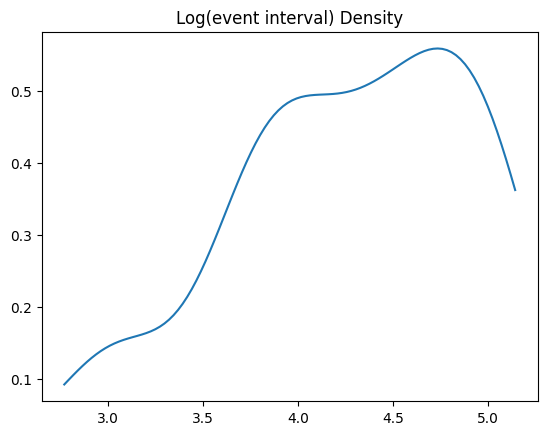

Optimal number of clusters (via silhouette): 2


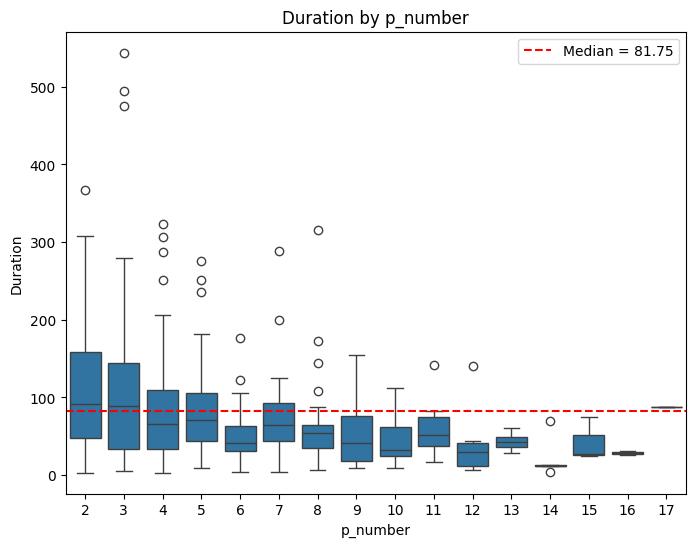

In [20]:
def see_assumption(df):
    df_sorted = df.sort_values(['pnr', 'eksd']).copy()
    df_sorted['prev_eksd'] = df_sorted.groupby('pnr')['eksd'].shift(1)
    df_sorted['p_number'] = df_sorted.groupby('pnr').cumcount() + 1
    df_filtered = df_sorted[df_sorted['p_number'] >= 2].copy()
    df_filtered['Duration'] = (df_filtered['eksd'] - df_filtered['prev_eksd']).dt.days
    overall_median = df_filtered.groupby('pnr')['Duration'].median().median()
    
    plt.figure(figsize=(8, 6))
    sns.boxplot(x='p_number', y='Duration', data=df_filtered)
    plt.axhline(overall_median, color='red', linestyle='--', label=f'Median = {overall_median}')
    plt.title('Duration by p_number')
    plt.legend()
    plt.show()

medA = see("medA", tidy)
see_assumption(medA)